# Simulations for JWST Cycle 2 proposal for observations of rocky exoplanets

In [1]:
# import area

import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi 
import pandexo.engine.justplotit as jpi
from pandexo.engine.bintools import bin_wave_to_R
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn
from os import listdir
import matplotlib

In [1]:
# non-pandexo imports

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn
from os import listdir
import matplotlib

### Produce emission models for LHS-3844b and [TOI-4481.01](https://exoplanetarchive.ipac.caltech.edu/overview/TOI%204481.01#planet_TOI-4481-01_collapsible) (following the work done for XRP 2022)

In [2]:
# define a function to calculate F_p/F_* at a given wavelength

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


def fp_over_fstar(wav_array,R_p, D_p, eps_array, spec_star, T_00, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
            
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*spec_star[i]*(R_star/D_p)**2))
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

In [3]:
### load emissivity data

eps_basalt_mir = np.loadtxt('data_Emily/xrp_samples/data/basaltMIR_emi.txt', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt_mir[:,0][::-1], eps_basalt_mir[:,1][::-1]

eps_granite_mir = np.loadtxt('data_Emily/xrp_samples/data/graniteMIR_emi.txt', delimiter=',')
wav_granite, eps_granite  = eps_granite_mir[:,0][::-1], eps_granite_mir[:,1][::-1]

eps_dunite_mir = np.loadtxt('data_Emily/xrp_samples/data/duniteMIR_emi.txt', delimiter=',')
wav_dunite, eps_dunite  = eps_dunite_mir[:,0][::-1], eps_dunite_mir[:,1][::-1]

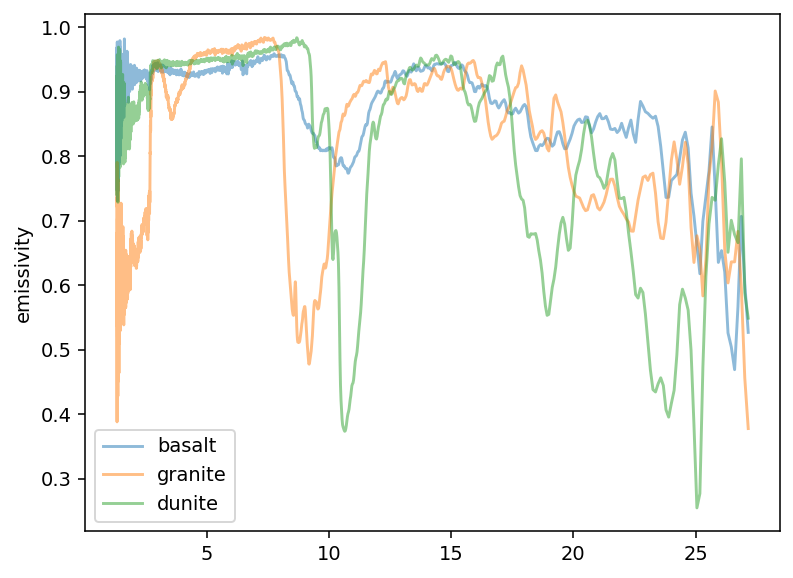

In [4]:
plt.figure()
plt.plot(wav_basalt, eps_basalt, alpha=0.5, label='basalt')
plt.plot(wav_granite, eps_granite, alpha=0.5, label='granite')
plt.plot(wav_dunite, eps_dunite, alpha=0.5, label='dunite')
#plt.xlim((0.5,1.2))
#plt.ylim((0,1))
plt.ylabel('emissivity')
plt.legend()

### LHS-3844b

In [5]:
## use equilibrium temperature as an approximation of substellar temperatures for basalt, white marble and basalt

T_star = 3036    # stellar temperature in K
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
a = 7.039*R_star

A_basalt = 0.0 
A_dunite = 0.4 
A_granite = 0.25 

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)
T_dunite = T_star*np.sqrt(R_star/(2*a))*(1 - A_dunite)**(0.25)
T_granite = T_star*np.sqrt(R_star/(2*a))*(1 - A_granite)**(0.25)

In [6]:
#### Produce planetary emission models for these three rock types

### define constant parameters for the model

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
#T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 
# calculate Fp/F_star using a blackbody stellar spectrum

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

### Calculate basalt model

spec_stellar_grid = spectres(wav_basalt, wav_stellar, spec_stellar)
spec_basalt = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, spec_stellar_grid, T_basalt, R_star, constant_T=True)

### Calculate white marble model

spec_stellar_grid = spectres(wav_dunite, wav_stellar, spec_stellar)
spec_dunite = fp_over_fstar(wav_dunite*10**-6, R_p, D_p, eps_dunite, spec_stellar_grid, T_dunite, R_star, constant_T=True)

### Calculate granite model

spec_stellar_grid = spectres(wav_granite, wav_stellar, spec_stellar)
spec_granite = fp_over_fstar(wav_granite*10**-6, R_p, D_p, eps_granite, spec_stellar_grid, T_granite, R_star, constant_T=True)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



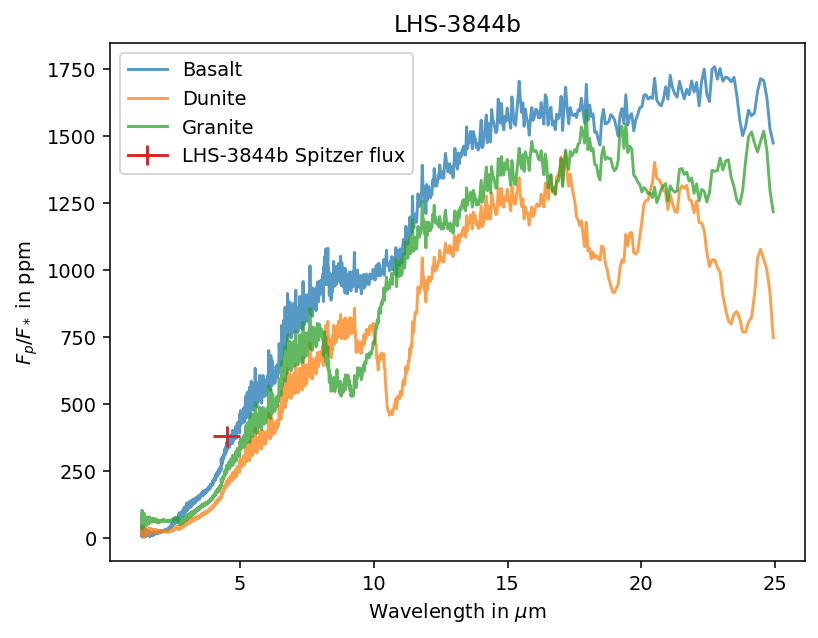

In [7]:
plt.figure()
fudge_factor = 2.0
plt.plot(wav_basalt, fudge_factor*spec_basalt*10**6,  alpha=0.75, label='Basalt')
plt.plot(wav_dunite, fudge_factor*spec_dunite*10**6,  alpha=0.75, label='Dunite')
plt.plot(wav_granite, fudge_factor*spec_granite*10**6, alpha=0.75, label='Granite')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.title('LHS-3844b')
plt.legend()

In [9]:
# save files

file_prefix = 'simulation_outputs/jwst_cycle_2/lhs3844b/'
np.savetxt(file_prefix + 'basalt' + '_model.txt', np.array([wav_basalt, fudge_factor*spec_basalt]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix + 'dunite' + '_model.txt', np.array([wav_dunite, fudge_factor*spec_dunite]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix + 'granite' + '_model.txt', np.array([wav_granite, fudge_factor*spec_granite]).T, delimiter='\t', fmt='%s')

### TOI-4481.01

In [10]:
## use equilibrium temperature as an approximation of substellar temperatures for basalt, white marble and basalt

T_star = 3573    # stellar temperature in K
R_p = 0.1258*7.1492*10**7  # planetary radius in meters
R_star = 0.425*6.957*10**8    # value obtained from Kreidberg et al.
a = 7.041*R_star

A_basalt = 0.0 
A_dunite = 0.4 
A_granite = 0.25 

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)
T_dunite = T_star*np.sqrt(R_star/(2*a))*(1 - A_dunite)**(0.25)
T_granite = T_star*np.sqrt(R_star/(2*a))*(1 - A_granite)**(0.25)

In [11]:
#### Produce planetary emission models for these three rock types

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 7.329            # J magnitude of the system (obtained from SIMBAD; had to search for GL 806)
                                    # which is alternate name of the star according to exomast
star_dict['temp'] = T_star            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 4.8              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

### load emissivity data

eps_basalt_mir = np.loadtxt('data_Emily/xrp_samples/data/basaltMIR_emi.txt', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt_mir[:,0][::-1], eps_basalt_mir[:,1][::-1]

eps_granite_mir = np.loadtxt('data_Emily/xrp_samples/data/graniteMIR_emi.txt', delimiter=',')
wav_granite, eps_granite  = eps_granite_mir[:,0][::-1], eps_granite_mir[:,1][::-1]

eps_dunite_mir = np.loadtxt('data_Emily/xrp_samples/data/duniteMIR_emi.txt', delimiter=',')
wav_dunite, eps_dunite  = eps_dunite_mir[:,0][::-1], eps_dunite_mir[:,1][::-1]

### Calculate basalt model

spec_stellar_grid = spectres(wav_basalt, wav_stellar, spec_stellar)
spec_basalt = fp_over_fstar(wav_basalt*10**-6, R_p, a, eps_basalt, spec_stellar_grid, T_basalt, R_star, constant_T=True)

### Calculate white marble model

spec_stellar_grid = spectres(wav_dunite, wav_stellar, spec_stellar)
spec_dunite = fp_over_fstar(wav_dunite*10**-6, R_p, a, eps_dunite, spec_stellar_grid, T_dunite, R_star, constant_T=True)

### Calculate granite model

spec_stellar_grid = spectres(wav_granite, wav_stellar, spec_stellar)
spec_granite = fp_over_fstar(wav_granite*10**-6, R_p, a, eps_granite, spec_stellar_grid, T_granite, R_star, constant_T=True)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



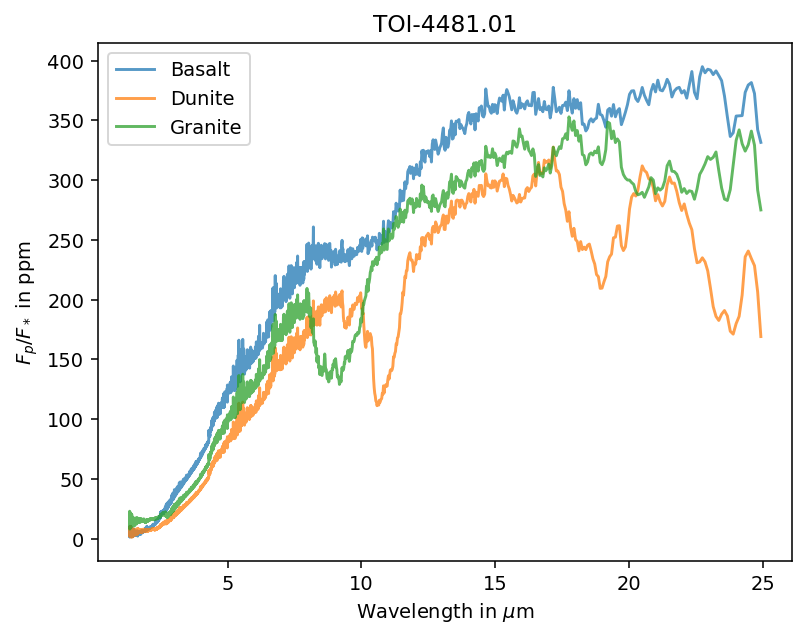

In [13]:
plt.figure()
fudge_factor = 2.0
plt.plot(wav_basalt, fudge_factor*spec_basalt*10**6,  alpha=0.75, label='Basalt')
plt.plot(wav_dunite, fudge_factor*spec_dunite*10**6,  alpha=0.75, label='Dunite')
plt.plot(wav_granite, fudge_factor*spec_granite*10**6, alpha=0.75, label='Granite')
#plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.title('TOI-4481.01')
plt.legend()

In [14]:
# save files

file_prefix = 'simulation_outputs/jwst_cycle_2/toi4481-01/'
np.savetxt(file_prefix + 'basalt' + '_model.txt', np.array([wav_basalt, fudge_factor*spec_basalt]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix + 'dunite' + '_model.txt', np.array([wav_dunite, fudge_factor*spec_dunite]).T, delimiter='\t', fmt='%s')
np.savetxt(file_prefix + 'granite' + '_model.txt', np.array([wav_granite, fudge_factor*spec_granite]).T, delimiter='\t', fmt='%s')

### Repeat the same for both planets but with the various basalts colelcted by Emily

#### LHS-3844b

In [15]:
T_star = 3036    # stellar temperature in K
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
a = 7.039*R_star


A_basalt = 0.0 

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)

In [16]:
#### Produce planetary emission models for these three rock types

### define constant parameters for the model

R_p = 0.116*7.1492*10**7   # planetary radius in meters
D_p = 8.97587e+8    # planet orbital distance in meters (assuming 0 eccentricity)
T_star = 3036    # stellar temperature in K
#R_star = 0.19*6.957e+8    # stellar radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al. 
# calculate Fp/F_star using a blackbody stellar spectrum

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

In [20]:
# load emissivity files

#(_, _, filenames) = walk('data_Emily/spectra_csv/csv - unaltered spectra/').next()

path = 'data_Emily/spectra_csv/csv - unaltered spectra/'
emissivity_files = listdir(path)

# for each emissivity file, generate models and write them to files

list_models = []
fudge_factor = 2.0   # in order to match the Spitzer point

for emissivity_file in emissivity_files:
    # load emissivity data
    eps = np.loadtxt(path + emissivity_file, delimiter=',')
    wav_eps, eps  = eps[:,0][::-1], eps[:,1][::-1]

    # match the stellar wavelength axis to the emissivity wavelength axis
    stellar_radiance_mod = spectres(wav_eps, wav_stellar, spec_stellar)

    wav_eps = wav_eps[~np.isnan(stellar_radiance_mod)]
    eps = eps[~np.isnan(stellar_radiance_mod)]
    stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

    # calculate model

    model = fp_over_fstar(wav_eps*10**-6, R_p, D_p, eps, stellar_radiance_mod, T_basalt, R_star, constant_T=True)

    list_models.append(model)

    # write output to a file

    file_prefix = 'simulation_outputs/jwst_cycle_2/lhs3844b/'
    np.savetxt(file_prefix + emissivity_file[:4] + '_model.txt', np.array([wav_eps, fudge_factor*model]).T, delimiter='\t', fmt='%s')

# also calculate a blackbody emission spectrum

eps_bb = np.ones(eps.size)
wav_eps_bb = np.copy(wav_eps)

# match the stellar wavelength axis to the emissivity wavelength axis
stellar_radiance_mod = spectres(wav_eps_bb, wav_stellar, spec_stellar)

wav_eps_bb = wav_eps_bb[~np.isnan(stellar_radiance_mod)]
eps_bb = eps_bb[~np.isnan(stellar_radiance_mod)]
stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

# calculate model

model_bb = fp_over_fstar(wav_eps_bb*10**-6, R_p, D_p, eps_bb, stellar_radiance_mod, T_basalt, R_star, constant_T=True)

file_prefix = 'simulation_outputs/jwst_cycle_2/lhs3844b/'
np.savetxt(file_prefix + 'blackbody' + '_model.txt', np.array([wav_eps_bb, fudge_factor*model_bb]).T, delimiter='\t', fmt='%s')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

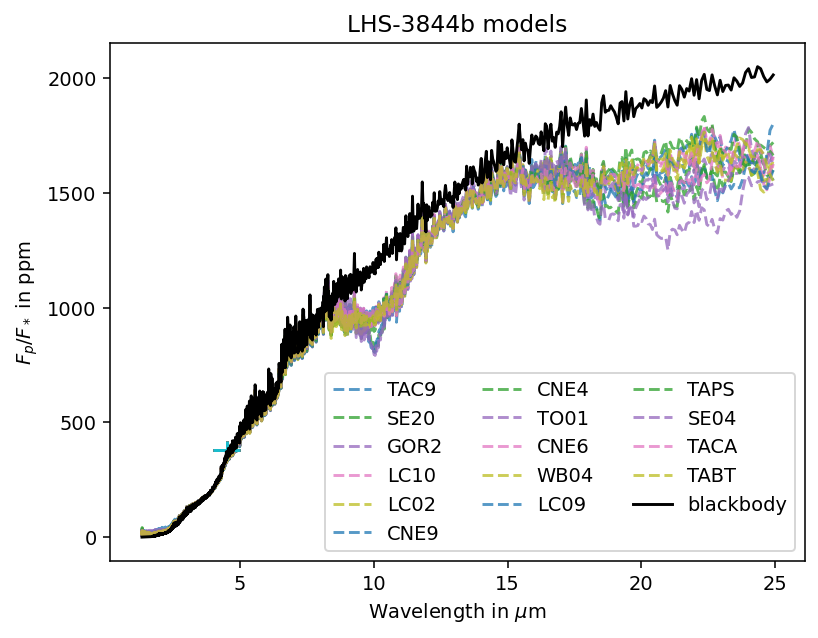

In [21]:
# plot all the models

plt.figure()
fudge_factor = 2.0
for i,model in enumerate(list_models):
    plt.plot(wav_eps, fudge_factor*model*10**6, ls='--', alpha=0.75, label=emissivity_files[i][:4])
    plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40)

plt.plot(wav_eps_bb, fudge_factor*model_bb*10**6, color='black', label='blackbody')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.title('LHS-3844b models')
plt.legend(loc='lower right', ncol=3)

#### TOI-4481.01

In [25]:
T_star = 3573    # stellar temperature in K
R_p = 0.1258*7.1492*10**7  # planetary radius in meters
R_star = 0.425*6.957*10**8    # value obtained from Kreidberg et al.
a = 7.041*R_star


A_basalt = 0.0 

T_basalt = T_star*np.sqrt(R_star/(2*a))*(1 - A_basalt)**(0.25)

In [26]:
#### Produce planetary emission models for these three rock types

#### calculate models for a grid model star

star_dict = {}
star_dict['mag'] = 7.329            # J magnitude of the system (obtained from SIMBAD; had to search for GL 806)
                                    # which is alternate name of the star according to exomast
star_dict['temp'] = T_star            #in K
#star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
star_dict['logg'] = 4.8              #log surface gravity cgs (from ExoMAST)
#star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
wav_stellar = sp.wave
spec_stellar = sp.flux

#### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

ind = np.where((wav_stellar > 1.0*10**-6) & (wav_stellar < 25.0*10**-6))
wav_stellar = wav_stellar[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
spec_stellar = spec_stellar[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
spec_stellar = spec_stellar*c/(wav_stellar)**2

spec_stellar = spec_stellar/(np.pi)   # convert from flux density to radiance
wav_stellar = wav_stellar*10**6   # convert to microns

In [27]:
# load emissivity files

#(_, _, filenames) = walk('data_Emily/spectra_csv/csv - unaltered spectra/').next()

path = 'data_Emily/spectra_csv/csv - unaltered spectra/'
emissivity_files = listdir(path)

# for each emissivity file, generate models and write them to files

list_models = []
fudge_factor = 2.0   # in order to match the Spitzer point

for emissivity_file in emissivity_files:
    # load emissivity data
    eps = np.loadtxt(path + emissivity_file, delimiter=',')
    wav_eps, eps  = eps[:,0][::-1], eps[:,1][::-1]

    # match the stellar wavelength axis to the emissivity wavelength axis
    stellar_radiance_mod = spectres(wav_eps, wav_stellar, spec_stellar)

    wav_eps = wav_eps[~np.isnan(stellar_radiance_mod)]
    eps = eps[~np.isnan(stellar_radiance_mod)]
    stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

    # calculate model

    model = fp_over_fstar(wav_eps*10**-6, R_p, D_p, eps, stellar_radiance_mod, T_basalt, R_star, constant_T=True)

    list_models.append(model)

    # write output to a file

    file_prefix = 'simulation_outputs/jwst_cycle_2/toi4481-01/'
    np.savetxt(file_prefix + emissivity_file[:4] + '_model.txt', np.array([wav_eps, fudge_factor*model]).T, delimiter='\t', fmt='%s')

# also calculate a blackbody emission spectrum

eps_bb = np.ones(eps.size)
wav_eps_bb = np.copy(wav_eps)

# match the stellar wavelength axis to the emissivity wavelength axis
stellar_radiance_mod = spectres(wav_eps_bb, wav_stellar, spec_stellar)

wav_eps_bb = wav_eps_bb[~np.isnan(stellar_radiance_mod)]
eps_bb = eps_bb[~np.isnan(stellar_radiance_mod)]
stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

# calculate model

model_bb = fp_over_fstar(wav_eps_bb*10**-6, R_p, D_p, eps_bb, stellar_radiance_mod, T_basalt, R_star, constant_T=True)

file_prefix = 'simulation_outputs/jwst_cycle_2/toi4481-01/'
np.savetxt(file_prefix + 'blackbody' + '_model.txt', np.array([wav_eps_bb, fudge_factor*model_bb]).T, delimiter='\t', fmt='%s')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

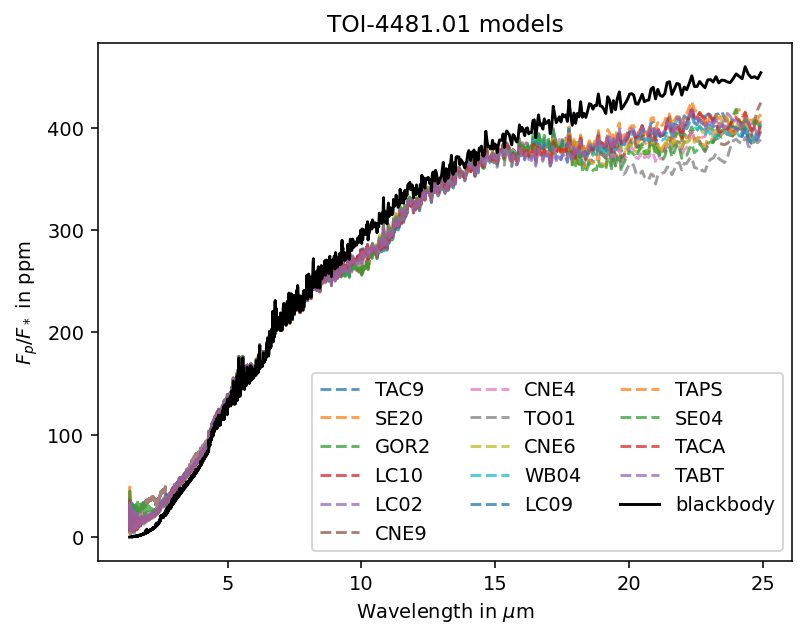

In [29]:
# plot all the models

plt.figure()
fudge_factor = 2.0
for i,model in enumerate(list_models):
    plt.plot(wav_eps, fudge_factor*model*10**6, ls='--', alpha=0.75, label=emissivity_files[i][:4])

plt.plot(wav_eps_bb, fudge_factor*model_bb*10**6, color='black', label='blackbody')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.title('TOI-4481.01 models')
plt.legend(loc='lower right', ncol=3)